In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
import networkx as nx


def load_data(data_path: str,):

    df = pd.concat(pd.read_excel(data_path, sheet_name=None), ignore_index=True)

    # Convert time column to datetime
    df['Time'] = df['Time'].astype("string")
    df['Time'] = pd.to_datetime(
        df['Time'],
        format='%H:%M:%S'
        )
    df['Time'] = [time.time() for time in df['Time']]

    time_1 = pd.to_datetime('06:00:00', format='%H:%M:%S').time()
    time_2 = pd.to_datetime('11:00:00', format='%H:%M:%S').time()
    time_3 = pd.to_datetime('17:00:00', format='%H:%M:%S').time()
    time_4 = pd.to_datetime('19:00:00', format='%H:%M:%S').time()

    df = df[(df['Time'] >= time_1) & (df['Time'] <= time_2) | (df['Time'] >= time_3) & (df['Time'] <= time_4)]

    return df


def clean_dataframes(dataframes: list):

    # Remove columns with NaN values
    for df in dataframes:
        df.dropna(axis=1, inplace=True)

    columns = []
    for df in dataframes:
        columns.append(df.columns.tolist())
    
    # Get the columns that are in all dfs
    common_columns = list(set(columns[0]).intersection(*columns))

    # Remove columns that are not in all dfs
    for df in dataframes:
        for column in df.columns:
            if column not in common_columns:
                df.drop([column], axis=1, inplace=True)

    # Remove Date and Time columns
    for df in dataframes:
        df.drop(['Date', 'Time'], axis=1, inplace=True)

    return dataframes
    

###### Read in the data ######

# Read in the data
no_leak_df = load_data(
    data_path='../data/data_no_leak.xlsx',
)

leak_df_1 = load_data(
    data_path='../data/data_leak_1.xlsx',
)

leak_df_2 = load_data(
    data_path='../data/data_leak_2.xlsx',
)

leak_df_3 = load_data(
    data_path='../data/data_leak_3.xlsx',
)

dfs = [no_leak_df, leak_df_1, leak_df_2, leak_df_3]

# Clean the dataframes
dfs = clean_dataframes(dfs)

# Create a dictionary of dataframes
dfs_dict = {
    'no_leak': dfs[0],
    'leak_1': dfs[1],
    'leak_2': dfs[2],
    'leak_3': dfs[3],
}

leak_pipe = 'Pipes-35(1)'

ModuleNotFoundError: No module named 'wntr'

/var/folders/6n/m7pn20js1vdgn8273nzq1zmr0000gn/T/ipykernel_4927/1744756854.py:5: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()


NameError: name 'leak_df' is not defined

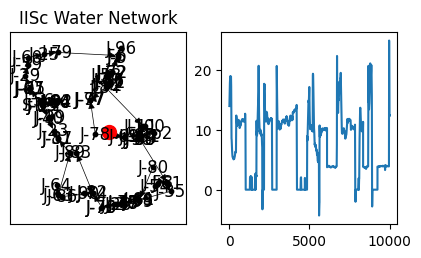

In [2]:
# Load epanet model
wn = wntr.network.WaterNetworkModel('../data/IISc_epanet.inp')

# Get networkx graph
G = wn.get_graph()

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Plot the networkx graph
plt.figure(figsize=(5, 2.5))
plt.subplot(1, 2, 1)
nx.draw_networkx(
    G, 
    pos=pos, 
    node_size=10, 
    node_color='k', 
    edge_color='k',
    width=0.5,
    )
plt.plot([1000], [1000], '.', color='r', markersize=20)
plt.title('IISc Water Network')


# Plot the data
plt.subplot(1, 2, 2)
plt.plot(no_leak_df['FM01_flow'].values[0:10000], label='No leak')
plt.plot(leak_df['FM01_head'].values[0:10000], label='With Leak')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (m)')
plt.legend()
plt.show()


Mean reconstruction error:
no_leak: 0.01670949353473623
leak_1: 0.1422861175831782
leak_2: 0.19380467827669895
leak_3: 0.07070464520885403


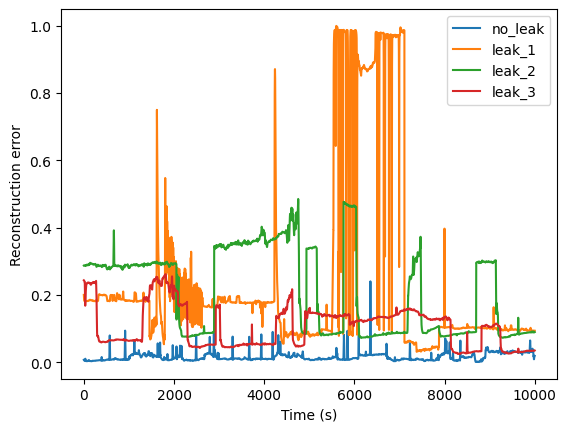

In [3]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

def get_reconstruction_error(
    df: pd.DataFrame,
    pca: PCA,
    ):

    # Compute reconstruction error
    reconstruction_error = df - pca.inverse_transform(pca.transform(df))
    l2_reconstruction_error = np.linalg.norm(reconstruction_error, axis=1)
    l2_reconstruction_error = l2_reconstruction_error / np.linalg.norm(df, axis=1)
    mean_reconstruction_error = np.mean(l2_reconstruction_error)

    return np.abs(reconstruction_error), l2_reconstruction_error, mean_reconstruction_error

# Perform PCA on the data
pca = PCA(n_components=10)

# Fit the PCA model on no leak data
pca.fit(dfs_dict['no_leak'], )

# Get the reconstruction error
recon_error = {}
l2_recon_error = {}
mean_recon_error = {}
for key, df in dfs_dict.items():
    recon_error[key], l2_recon_error[key], mean_recon_error[key] = \
        get_reconstruction_error(df, pca)

# Print the mean reconstruction error
print('Mean reconstruction error:')
for key, error in mean_recon_error.items():
    print(f'{key}: {error}')

# Plot the reconstruction error
plt.figure()
for key, error in l2_recon_error.items():
    plt.plot(error[0:10000], label=key)
plt.xlabel('Time (s)')
plt.ylabel('Reconstruction error')
plt.legend()
plt.show()



In [4]:
square_domain = {
    'x_min': 1e8,
    'x_max': -1e8,
    'y_min': 1e8,
    'y_max': -1e8,
}

for node, _pos in pos.items():
    if _pos[0] < square_domain['x_min']:
        square_domain['x_min'] = _pos[0]
    if _pos[0] > square_domain['x_max']:
        square_domain['x_max'] = _pos[0]
    if _pos[1] < square_domain['y_min']:
        square_domain['y_min'] = _pos[1]
    if _pos[1] > square_domain['y_max']:
        square_domain['y_max'] = _pos[1]

# Get the node positions of sensors
sensor_nodes = [
    'J-5', 'J-23', 'J-35', 'J-50', 'J-60', 'J-68', 'J-74', 'J-78', 'J-90',
    ]
sensor_nodes_pos = {}
for node, _pos in pos.items():
    if node in sensor_nodes:
        sensor_nodes_pos[node] = _pos


In [35]:
target = recon_error['leak_1'].values[:1000, 0:9]

X = np.zeros((target.shape[0]*9, 2))
Y = np.zeros((target.shape[0]*9))
for i in range(0, 9):
    X[i*target.shape[0]:(i+1)*target.shape[0], 0] = sensor_nodes_pos[sensor_nodes[i]][0]
    X[i*target.shape[0]:(i+1)*target.shape[0], 1] = sensor_nodes_pos[sensor_nodes[i]][1]

    Y[i*target.shape[0]:(i+1)*target.shape[0]] = target[:, i]

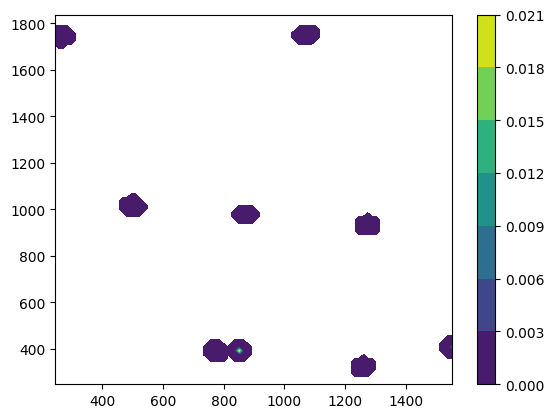

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

rf = GaussianProcessRegressor()
rf.fit(X, Y)

x = np.linspace(square_domain['x_min'], square_domain['x_max'], 100)
y = np.linspace(square_domain['y_min'], square_domain['y_max'], 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(0, 100):
    for j in range(0, 100):
        Z[i, j] = rf.predict(np.array([[X[i, j], Y[i, j]]]))

plt.figure()
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

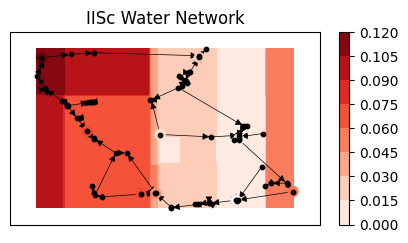

In [28]:
sensor_X = np.zeros((9, 2))
for i in range(0, 9):
    sensor_X[i, 0] = sensor_nodes_pos[sensor_nodes[i]][0]
    sensor_X[i, 1] = sensor_nodes_pos[sensor_nodes[i]][1]


# Plot the sensor nodes
plt.figure(figsize=(5, 2.5))
plt.contourf(X, Y, Z, cmap='Reds')
plt.colorbar()
nx.draw_networkx(
    G,
    pos=pos,
    node_size=10,
    node_color='k',
    edge_color='k',
    width=0.5,
    with_labels=False,
    )
plt.scatter(sensor_X[:, 0], sensor_X[:, 1], c=recon_error['leak_1'].values[0, 0:9], s=50, cmap='Reds')
plt.title('IISc Water Network')
plt.show()


In [9]:
recon_error['leak_1'].values[0, 0:9]

array([0.024, 0.072, 0.056, 0.001, 0.12 , 0.   , 0.047, 0.016, 0.071])